In [1]:
import os
import torch
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from transformers import pipeline, BertTokenizer, TFBertForSequenceClassification, DetrImageProcessor, DetrForObjectDetection
from PIL import Image
from diffusers import StableDiffusionPipeline
from huggingface_hub import login



2025-02-13 20:12:49.807163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 20:12:49.823747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739473969.843887   30407 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739473969.849599   30407 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 20:12:49.870446: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.config.set_visible_devices([], 'GPU')

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Crecimiento de memoria configurado para las GPUs.")
    except RuntimeError as e:
        print(f"Error al configurar crecimiento de memoria: {e}")

Crecimiento de memoria configurado para las GPUs.


# EJERCICIOS

## EJERCICIO 1
Utiliza un modelo preentrenado de Hugging Face que clasifique textos en neutral y subjetivo y clasifica las siguientes opiniones:

* "I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors."

* "The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us."

* "This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting."

* "The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays"

El resultado lo tiene que mostrar  de la siguiente forma:

* Texto: XXX 
* Clasificación: Y con una confianza del X%

In [3]:
classifier = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment")

opiniones = [
    "I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors.",
    "The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us.",
    "This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting.",
    "The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays."
]

for opinion in opiniones:
    resultado = classifier(opinion)[0]
    label = "Subjetivo" if resultado['label'] != "LABEL_2" else "Neutral"
    confianza = resultado['score'] * 100
    print(f"Texto: {opinion}\nClasificación: {label} con una confianza del {confianza:.2f}%\n")


Device set to use cuda:0


Texto: I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors.
Clasificación: Neutral con una confianza del 98.94%

Texto: The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us.
Clasificación: Subjetivo con una confianza del 97.66%

Texto: This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting.
Clasificación: Neutral con una confianza del 87.14%

Texto: The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays.
Clasificación: Subjetivo con una confianza del 55.95%



## EJERCICIO 2
Traduce el siguiente texto del inglés al español usando un modelo preentrenado de Hugging Face: "The achievements of artificial intelligence are impressive."

In [4]:
%pip install sentencepiece

translator = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es")
translation = translator("The achievements of artificial intelligence are impressive.")
print(f"Texto traducido: {translation[0]['translation_text']}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


/home/iabd/miniconda3/envs/iabd_hug/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


Texto traducido: Los logros de la inteligencia artificial son impresionantes.


## EJERCICIO 3
Genera un texto continuando la siguiente frase: "Los logros de la inteligencia artificial..."

Usa gpt2

In [5]:
gpt2 = pipeline("text-generation", model="DeepESP/gpt2-spanish")
text = "Los logros de la inteligencia artificial"
generated = gpt2(text)
print(f"Texto generado: {generated[0]['generated_text']}")

Device set to use cuda:0


Texto generado: Los logros de la inteligencia artificial se habían convertido en éxitos académicos. 

Cosas como la investigación del caso de Jeremy Bowen, los descubrimientos de los programas de entrevistas y los estudios de los primeros años de la investigación de la serie de Bowen


## EJERCICIO 4
Entrena un modelo de análisis de sentimientos en un pequeño conjunto de datos personalizado usando un modelo de Hugging Face. Supongamos que tienes el siguiente conjunto de datos (evidentemente con este conjunto de datos tan pequeño no vamos a ningún lado, se trata de simular el proceso):

* "I enjoy playing football.", Positivo
* "The restaurant had poor service.", Negativo
* "Such a beautiful day outside!", Positivo

Si quieres puedes usar el modelo bert-base-uncased

Los pasos generales que puedes seguir son:
* Prepara los datos de entrenamiento (X e y).
* Carga un modelo preentrenado de Transformers y su tokenizador.
* Preprocesa los datos para que sean compatibles con el modelo.
* Compila el modelo con una función de pérdida y un optimizador.
* Entrena el modelo con los datos.
* Evalúa el modelo con algunos datos ("I enjoy playing basketboall.", Positivo y "I hate rainning days.", Negativo).
* Predice nuevos datos ("The restaurant had a good service.")

In [3]:
# Preparar los datos de entrenamiento
texts = [
    "I enjoy playing football.",
    "The restaurant had poor service.",
    "Such a beautiful day outside!"
]
labels = [1, 0, 1]  # 1 para positivo, 0 para negativo

# Cargar el modelo preentrenado y el tokenizador
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Preprocesar los datos
encoded_data = tokenizer(
    texts,
    padding=True,
    truncation=True,
    return_tensors='tf'
)

# Convertir los datos a formato TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((
    dict(encoded_data),
    labels
)).shuffle(100).batch(2)

# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    dataset,
    epochs=3
)

# Evaluar el modelo con datos de prueba
test_texts = [
    "I enjoy playing basketball.",
    "I hate rainning days."
]
test_labels = [1, 0]

test_encoded = tokenizer(
    test_texts,
    padding=True,
    truncation=True,
    return_tensors='tf'
)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encoded),
    test_labels
)).batch(2)

test_results = model.evaluate(test_dataset)
print(f"\nTest results - Loss: {test_results[0]:.4f} - Accuracy: {test_results[1]:.4f}")

# Predicción de nuevos datos
new_text = ["The restaurant had a good service."]
new_encoded = tokenizer(
    new_text,
    padding=True,
    truncation=True,
    return_tensors='tf'
)

predictions = model.predict(dict(new_encoded))
predicted_label = tf.nn.softmax(predictions.logits, axis=-1)

print("\n###### predicción #####")
print(f"Texto: {new_text[0]}")
print(f"Probabilidad Negativo: {predicted_label[0][0]:.4f}")
print(f"Probabilidad Positivo: {predicted_label[0][1]:.4f}")
print(f"Sentimiento predicho: {'Positivo' if predicted_label[0][1] > 0.5 else 'Negativo'}")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


I0000 00:00:1739474006.343183   30530 service.cc:148] XLA service 0x7751041802b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739474006.343233   30530 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-13 20:13:26.373467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739474006.451137   30529 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 26s 276ms/step - loss: 0.6854 - accuracy: 0.3333
Epoch 2/3
2/2 [==============================] - 1s 203ms/step - loss: 0.6964 - accuracy: 0.6667
Epoch 3/3
1/1 [==============================] - 3s 3s/step - loss: 0.6968 - accuracy: 0.5000

Test results - Loss: 0.6968 - Accuracy: 0.5000
1/1 [==============================] - 3s 3s/step

###### predicción #####
Texto: The restaurant had a good service.
Probabilidad Negativo: 0.5156
Probabilidad Positivo: 0.4844
Sentimiento predicho: Negativo


## EJERCICIO 5
Utiliza un modelo preentrenado de Hugging Face para generar una descripción (caption) para una imagen dada.

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

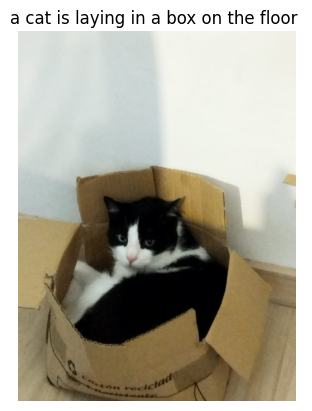

In [7]:
vit_gpt2 = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
caption = vit_gpt2("mika.jpg")

img = mpimg.imread('mika.jpg')
plt.imshow(img)
plt.title(caption[0]['generated_text'])
plt.axis('off')
plt.show()

## EJERCICIO 6
Elige un modelo de detcción de objetos de Hugging Face y aplícalo a una imagen.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


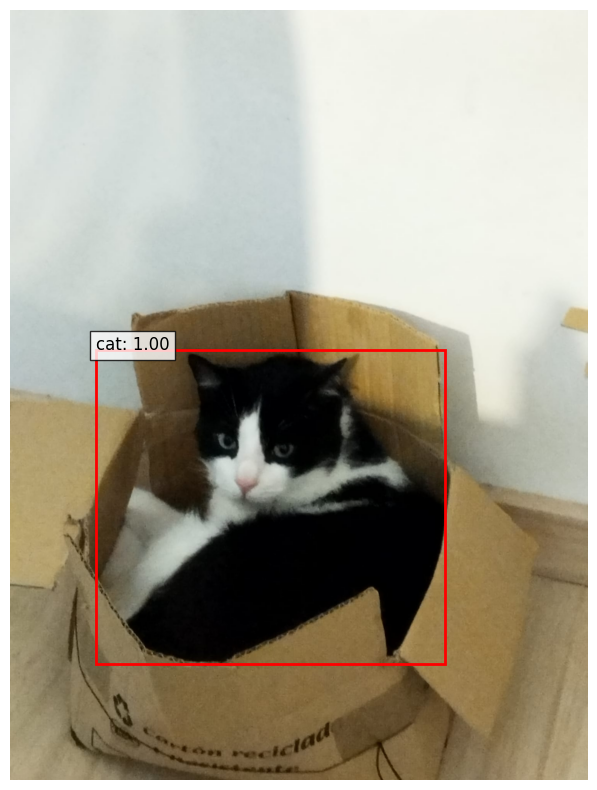

In [8]:
%pip install timm

def detect_objects(image_path, confidence_threshold=0.9):
    # Cargar el procesador de imágenes y el modelo
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

    # Cargar y procesar la imagen
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    
    # Realizar la detección
    outputs = model(**inputs)
    
    # Convertir outputs a probabilidades
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > confidence_threshold
    
    # Convertir cajas a formato correcto
    target_sizes = torch.tensor([image.size[::-1]])
    postprocessed_outputs = processor.post_process_object_detection(
        outputs, 
        target_sizes=target_sizes, 
        threshold=confidence_threshold
    )[0]
    
    # Visualizar resultados
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    
    # Dibujar cada detección
    for score, label, box in zip(
        postprocessed_outputs['scores'], 
        postprocessed_outputs['labels'], 
        postprocessed_outputs['boxes']
    ):
        box = box.tolist()
        
        # Crear el rectángulo
        rect = patches.Rectangle(
            (box[0], box[1]), 
            box[2] - box[0], 
            box[3] - box[1],
            linewidth=2, 
            edgecolor='r', 
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Añadir etiqueta con el nombre del objeto y la probabilidad
        class_name = model.config.id2label[label.item()]
        text = f'{class_name}: {score.item():.2f}'
        plt.text(
            box[0], box[1], 
            text, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=12
        )
    
    plt.axis('off')
    plt.show()


detect_objects("mika.jpg")

## EJERCICIO 7
Genera un texto usando un modelo de generción de texto (gpt2).
Usa el texto creado como entrada para un modelo de generación de imágenes (stable-diffusion).

El texto de entrada para el primer modelo va a ser

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
100%|██████████| 50/50 [06:14<00:00,  7.49s/it]


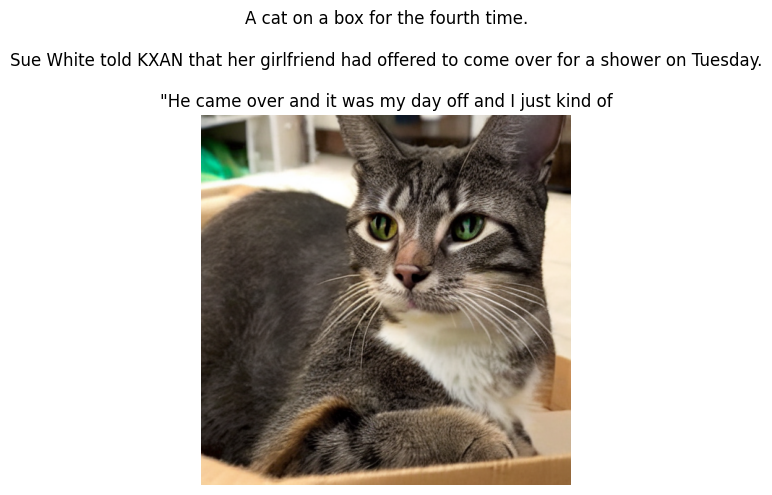

In [4]:
gpt2 = pipeline("text-generation", model="openai-community/gpt2")
text = "A cat on a box"
generated = gpt2(text)

pipe = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5")
prompt = generated[0]['generated_text']
image = pipe(prompt).images[0]

plt.imshow(image)
plt.title(prompt)   
plt.axis('off')
plt.show()

## EJERCICIO 8 (OPCIONAL)
Encadena con sentido tres modelos de Hugging Face para realizar una tarea de NLP, una de visión y una de generación de imágenes.